In [42]:

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import branca.colormap as cm
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestRegressor
rs = 59543

In [43]:
train = pd.read_csv('./train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test = pd.read_csv('./test.csv', index_col='ID_LAT_LON_YEAR_WEEK')

In [44]:
train.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 no

In [46]:
{col.split('_')[0] for col in train.columns}

{'CarbonMonoxide',
 'Cloud',
 'Formaldehyde',
 'NitrogenDioxide',
 'Ozone',
 'SulphurDioxide',
 'UvAerosolIndex',
 'UvAerosolLayerHeight',
 'emission',
 'latitude',
 'longitude',
 'week',
 'year'}

In [47]:
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending=False).head(20)

UvAerosolLayerHeight_aerosol_pressure                      78584
UvAerosolLayerHeight_solar_zenith_angle                    78584
UvAerosolLayerHeight_aerosol_height                        78584
UvAerosolLayerHeight_aerosol_optical_depth                 78584
UvAerosolLayerHeight_sensor_zenith_angle                   78584
UvAerosolLayerHeight_sensor_azimuth_angle                  78584
UvAerosolLayerHeight_solar_azimuth_angle                   78584
NitrogenDioxide_NO2_slant_column_number_density            18320
NitrogenDioxide_tropopause_pressure                        18320
NitrogenDioxide_tropospheric_NO2_column_number_density     18320
NitrogenDioxide_absorbing_aerosol_index                    18320
NitrogenDioxide_cloud_fraction                             18320
NitrogenDioxide_sensor_altitude                            18320
NitrogenDioxide_sensor_azimuth_angle                       18320
NitrogenDioxide_sensor_zenith_angle                        18320
NitrogenDioxide_solar_azi

In [48]:
# Number of missing values for each year
train.isnull().groupby(train['year']).sum().sum(axis=1)

year
2019    309254
2020    333338
2021    347499
dtype: int64

In [49]:
train[['year', 'emission']].describe()

,year,emission
count,79023.000000,79023.000000
mean,2020.000000,81.940552
std,0.816502,144.299648
min,2019.000000,0.000000
25%,2019.000000,9.797995
50%,2020.000000,45.593445
75%,2021.000000,109.549595
max,2021.000000,3167.768000


In [50]:
# Dataframes for visualization
train_plot = train.copy(deep=True)
train_plot['date'] = pd.to_datetime(train_plot['year'].astype(str) + '-' + train_plot['week_no'].astype(str) + '-1', format='%Y-%W-%w') # 1 is a monday and %w day of week otherwise throws error

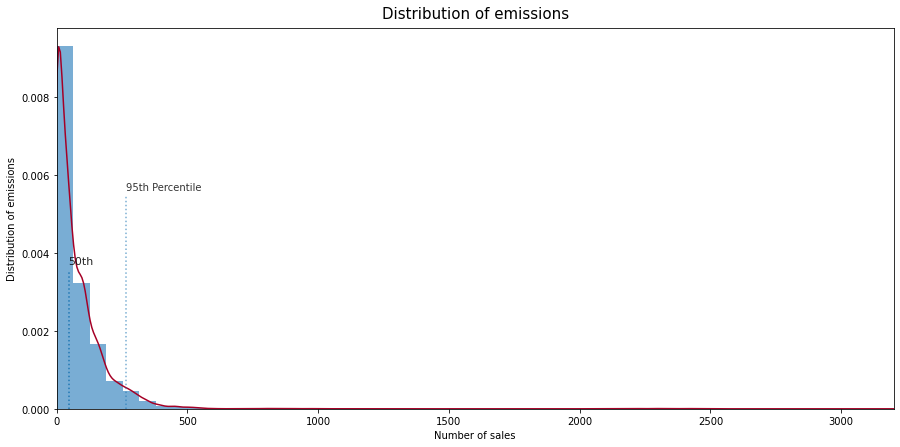

In [51]:
train['emission'].plot(kind = "hist", density = True, alpha = 0.65, bins = 50, colormap='tab20c', figsize=(15,10)) # change density to true, because KDE uses density
train['emission'].plot(kind = "kde", colormap='RdYlBu', figsize=(15,7))

quant_50, quant_95 = train['emission'].quantile(0.5), train['emission'].quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_95, 0.6, 0.56]]
for i in quants:
    plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
plt.xlabel('Number of sales')
plt.xlim((0, 3200))
plt.ylabel('Distribution of emissions')
plt.text(quant_50, .0037, "50th", size=11, alpha=.85)
plt.text(quant_95, .0056, "95th Percentile", size=10, alpha=.8)

plt.title('Distribution of emissions', size=15, pad=10)
plt.show()

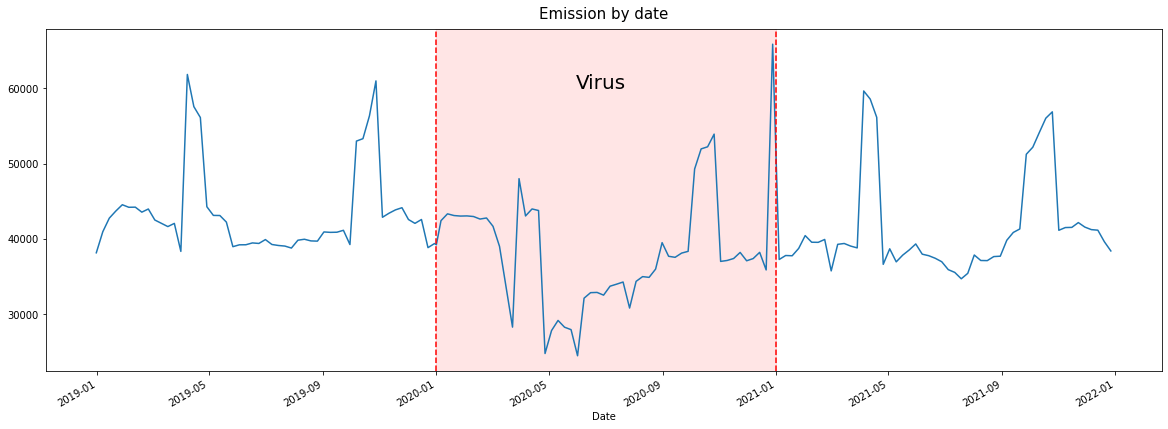

In [52]:
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='red', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='red')

plt.text(pd.Timestamp ('2020-05-30'), 60000, "Virus", size = 20)

plt.title('Emission by date', size=15, pad=10)
plt.show()

In [53]:
mask = train_plot['date'].dt.year != 2020
train_plot_no_2020 = train_plot[mask]

In [55]:
train.drop_duplicates(subset=['latitude', 'longitude']).shape[0]

497

In [56]:
zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
zero_emissions

,,emission
latitude,longitude,
-2.898,29.002,0.0
-2.859,29.041,0.0
-2.841,29.159,0.0
-2.817,29.283,0.0
-2.496,28.504,0.0
-1.974,28.526,0.0
-1.839,28.761,0.0
-1.833,28.467,0.0
-1.730,28.470,0.0


In [57]:
grouped = train.groupby(['latitude', 'longitude'])['emission'].sum().reset_index()

colormap = cm.LinearColormap(['green', 'red'], vmin=0, vmax=75000)

m = folium.Map(location=[grouped['latitude'].mean(), grouped['longitude'].mean()])

for _, row in grouped.iterrows():
    rows_emission = row['emission']
    color = 'blue' if rows_emission == 0 else colormap(rows_emission) if rows_emission < 10**5 else 'black'
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=np.sqrt(row['emission'])*15,
        color=color,
        fill=True,
        fill_color= color
    ).add_to(m)

m.fit_bounds(m.get_bounds())
m

<AxesSubplot:title={'center':'Total emissions by location'}>

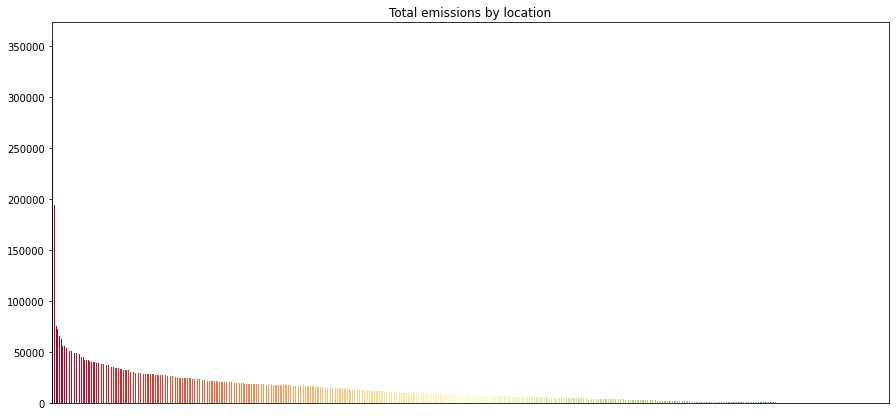

In [58]:
grouped['emission'].sort_values(ascending = False).plot(kind = 'bar', title = 'Total emissions by location', xticks = [], figsize=(15, 7), color=sns.color_palette('RdYlGn', n_colors=497))

In [59]:
np.array_equal(test[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values, train[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values)

True

In [60]:
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + train['week_no'].astype(str) + '-1', format='%Y-%W-%w')

In [61]:
train.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

In [62]:
# Calculate the average monthly sales for non-virus years (2019 and 2021)
avg_emission_non_virus = train[train['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()

# Calculate the average monthly for virus year (2020)
avg_emission_virus = train[train['year'] == 2020].groupby('week_no')['emission'].mean()

# Calculate the ratios for each month
ratios_for_weeks = avg_emission_non_virus/avg_emission_virus

# Multiply the num_sold column for each row in 2020 by the corresponding ratio for the week of that row
train.loc[train['year'] == 2020, 'emission'] *= train['week_no'].map(ratios_for_weeks)

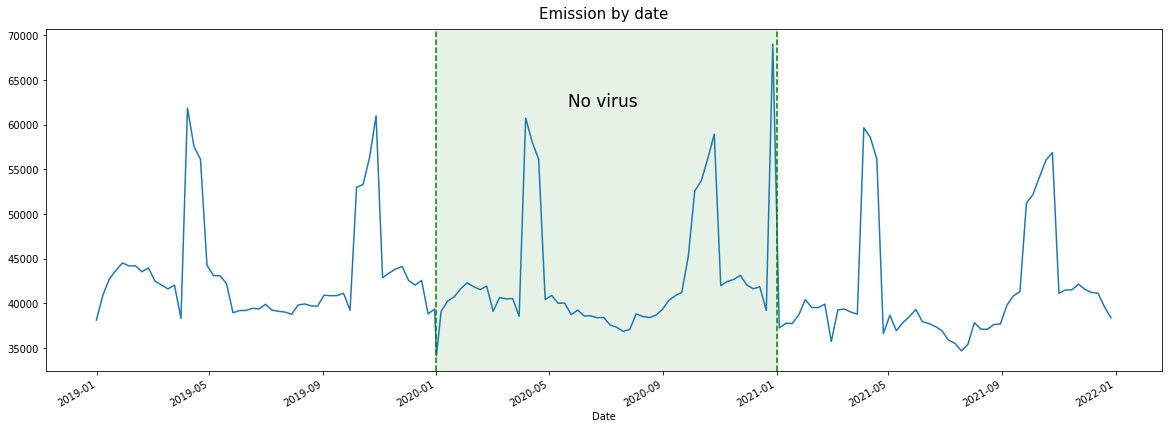

In [63]:
train.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp('2020-05-22'), 62000, "No virus", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()

In [64]:
train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'] = np.power(train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'], 1/1.5)

In [65]:
train['season'] = train['date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)

In [66]:
train['holidays'] = (train['week_no'].isin([0, 51, 12, 30]))

In [67]:
train['week_sin'] = np.sin(2 * np.pi * train['week_no']/53)
train['week_cos'] = np.cos(2 * np.pi * train['week_no']/53)

# If season imporved LB and didn't introduce more overfitting it would be a good idea to create cyclic features for it
# train['season_sin'] = np.sin(2 * np.pi * train['season']/4)
# train['season_cos'] = np.cos(2 * np.pi * train['season']/4)

In [68]:
# From Yang Zhou https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling
train['rot_15_x'] = (np.cos(np.radians(15)) * train['longitude']) + (np.sin(np.radians(15)) * train['latitude'])

train['rot_15_y'] = (np.cos(np.radians(15)) * train['latitude']) + (np.sin(np.radians(15)) * train['longitude'])

train['rot_30_x'] = (np.cos(np.radians(30)) * train['longitude']) + (np.sin(np.radians(30)) * train['latitude'])

train['rot_30_y'] = (np.cos(np.radians(30)) * train['latitude']) + (np.sin(np.radians(30)) * train['longitude'])

In [69]:
training_cols = ['latitude', 'longitude', 'year', 'week_sin', 'week_cos', 'holidays', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y']

In [70]:
X_train = train.drop(columns='emission')
y = train['emission']

In [71]:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'), QuantileTransformer(output_distribution='normal', random_state=rs), StandardScaler()
)

In [72]:
X_transformed = pipeline.fit_transform(X_train[training_cols])

## Model training

In [74]:
model = RandomForestRegressor(min_samples_leaf=6, random_state=rs)

model.fit(X_transformed, y)

RandomForestRegressor(min_samples_leaf=6, random_state=59543)

In [75]:
# 3 groups for 2019, 2020 and 2021
gkf = GroupKFold(3)

scores = -cross_val_score(model, X_transformed, y, scoring="neg_root_mean_squared_error", cv=gkf.split(X_transformed, y, groups=train['year']))

print(f'Training RMSE: {mean_squared_error(y, model.predict(X_transformed), squared=False):.2f}')
print(f"Cross validation RMSE: {scores.mean():.2f}")

Training RMSE: 14.95
Cross validation RMSE: 22.27


In [77]:
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['week_no'].astype(str) + '-1', format='%Y-%W-%w')

test.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

test['week_sin'] = np.sin(2 * np.pi * test['week_no']/53)
test['week_cos'] = np.cos(2 * np.pi * test['week_no']/53)

test['holidays'] = (test['week_no'].isin([0, 51, 12, 30]))

test['rot_15_x'] = (np.cos(np.radians(15)) * test['longitude']) + (np.sin(np.radians(15)) * test['latitude'])
test['rot_15_y'] = (np.cos(np.radians(15)) * test['latitude']) + (np.sin(np.radians(15)) * test['longitude'])
test['rot_30_x'] = (np.cos(np.radians(30)) * test['longitude']) + (np.sin(np.radians(30)) * test['latitude'])
test['rot_30_y'] = (np.cos(np.radians(30)) * test['latitude']) + (np.sin(np.radians(30)) * test['longitude'])

X_test = pd.DataFrame(data=pipeline.transform(test[training_cols]), index=test.index)

In [78]:
predictions = model.predict(X_test)
predictions

array([ 3.64541984,  3.90614104,  4.17081166, ..., 29.3490367 ,
       29.14923178, 28.90784533])

In [79]:
predictions[predictions < 0] = 0
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
predictions[mask] = 0

In [81]:
sample_submission = pd.read_csv('./sample_submission.csv', index_col='ID_LAT_LON_YEAR_WEEK')
sample_submission['emission'] = predictions * 1.07

In [82]:
sample_submission.loc[test['longitude'] == 29.321, 'emission'] = train.loc[(train['year'] == 2021) & (train['week_no'] <= 48) & (train['longitude'] == 29.321), 'emission'].values

In [83]:
sample_submission.head()

,emission
ID_LAT_LON_YEAR_WEEK,
ID_-0.510_29.290_2022_00,3.900599
ID_-0.510_29.290_2022_01,4.179571
ID_-0.510_29.290_2022_02,4.462768
ID_-0.510_29.290_2022_03,4.465496
ID_-0.510_29.290_2022_04,4.509451


In [84]:
pred_plot = pd.concat([test, sample_submission], axis=1)

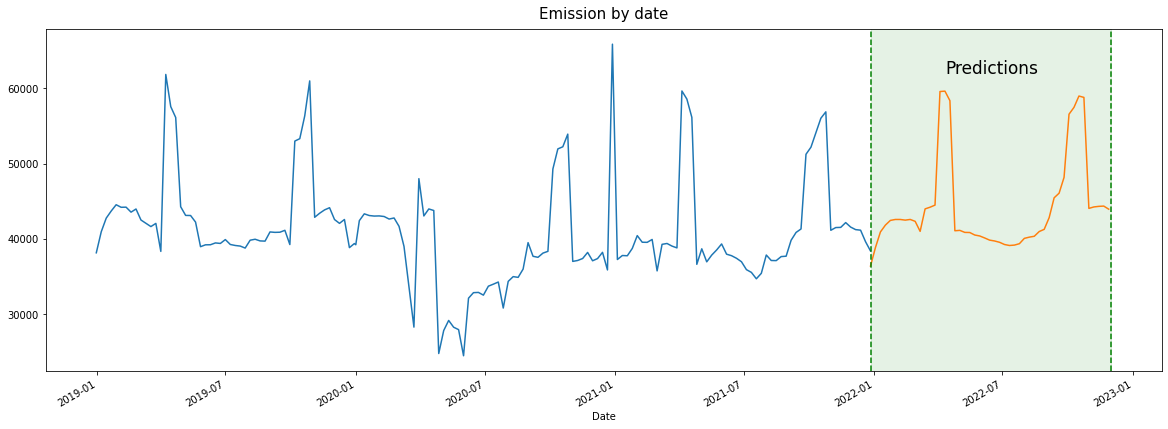

In [85]:
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
pred_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-12-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2021-12-27'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp ('2022-04-12'), 62000, "Predictions", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()

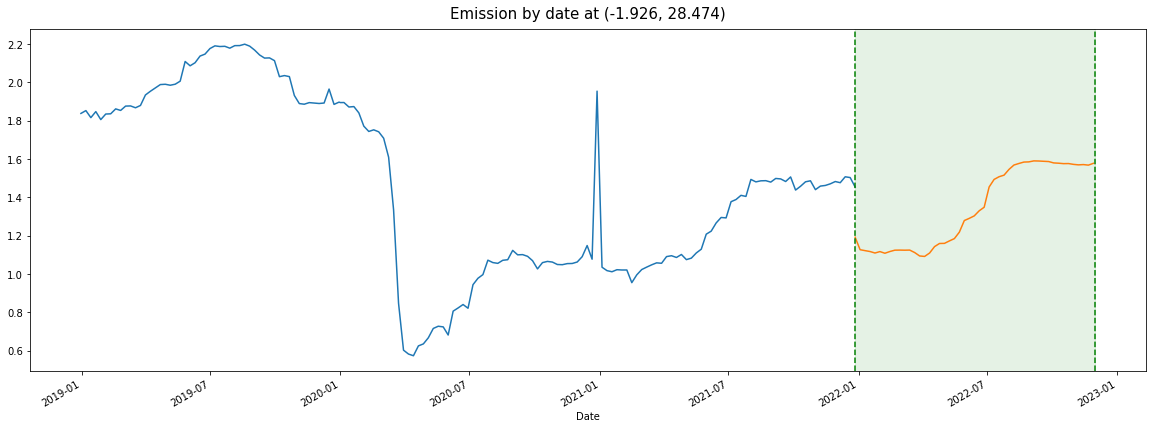

In [86]:
rand_latitude, rand_longitude = test.sample()[['latitude', 'longitude']].values.reshape((-1, ))

train_plot[(train_plot['latitude'] == rand_latitude) & (train_plot['longitude'] == rand_longitude)].groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
pred_plot[(pred_plot['latitude'] == rand_latitude) & (pred_plot['longitude'] == rand_longitude)].groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-12-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2021-12-27'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-01'), linestyle = "--", color='green')

plt.title(f'Emission by date at ({rand_latitude}, {rand_longitude})', size=15, pad=10)
plt.show()

## Save submission

In [88]:
sample_submission.to_csv('./fnsubmission.csv')